## Experiment 1: BFGS vs Adam on synthetic SE data

In [1]:
%load_ext autoreload
%autoreload 2
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import SGD
from gp import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


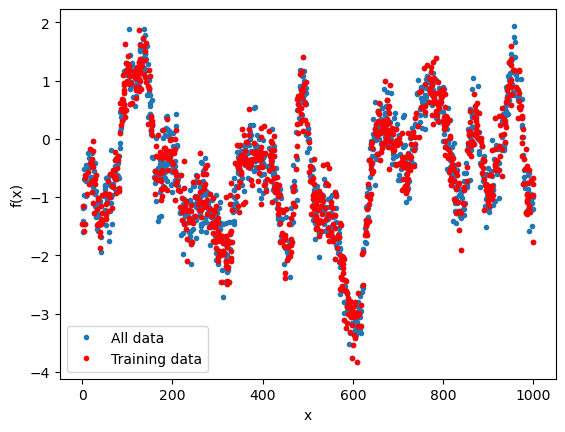

In [37]:
n_data = 2000
n_train = 1000
X = 1000*torch.rand(n_data,1)
X = X.to(device)
hypers = [1, 20, 0.1]
gp_true = GP(hypers = hypers)
y = gp_true.sample_from_prior(X)
#y = y.squeeze()    # make sure it’s 1D

X_data = X.detach()
y_data = y.detach()

idx = torch.randperm(n_data)[:n_train]
# subset of the data

X_train = X_data[idx]
y_train = y_data[idx]

plt.plot(X_data.cpu(), y_data.cpu(), '.', label="All data")
plt.plot(X_train.cpu(), y_train.cpu(), 'r.', label="Training data")
plt.legend()

plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

In [60]:
#training setting: modify for Adam vs BFGS
M=30
tol = 1e-2
optimizer = 'BFGS' ## or 'Adam'
if optimizer == 'BFGS':
    n_steps = 50 
    lr = 0.01
elif optimizer == 'Adam':
    n_steps = 2000 
    lr = 0.1

In [61]:
X_train = X_train.to(device)
y_train = y_train.to(device)

In [62]:
# Vanilla GP (NLL)
gp_nll = GP(X_train, y_train, kernel = 'SE')

d_train1 = gp_nll.train_step(obj = 'nll', opt_name=optimizer, lr=lr, n_steps=n_steps, tol=tol)

In [63]:
# SparseGP (ELBO)
gp_elbo = GP(X_train, y_train, kernel = 'SE', M=M, method = 'VFE')

d_train2 = gp_elbo.train_step(obj = 'elbo', opt_name=optimizer, lr=lr, n_steps=n_steps, tol=tol)

[init_Z_kmeanspp] KMeans finished in 0.107 seconds


In [64]:
# SparseGP (proj)
gp_proj = GP(X_train, y_train, kernel = 'SE', M=M, method = 'proj-repulsive')

d_train3 = gp_proj.train_step(obj = 'proj', opt_name=optimizer, lr=lr, n_steps=n_steps, tol=tol)


In [65]:
print("Negative log-likelihood per method:")
print(f"NLL: {gp_nll.nll().cpu().detach().numpy().flatten()}")
print(f"ELBO: {gp_elbo.nll().cpu().detach().numpy().flatten()}")
print(f"Proj: {gp_proj.nll().cpu().detach().numpy().flatten()}")

print("Hypers:")

print(f"NLL: {gp_nll.hypers.cpu().detach().numpy().flatten()}")
print(f"ELBO: {gp_elbo.hypers.cpu().detach().numpy().flatten()}")
print(f"Proj: {gp_proj.hypers.cpu().detach().numpy().flatten()}")




Negative log-likelihood per method:
NLL: [344.3482]
ELBO: [446.8388]
Proj: [353.93317]
Hypers:
NLL: [ 1.10939942 20.61353569  0.0902316 ]
ELBO: [ 1.71081064 35.18432323  0.13107103]
Proj: [ 1.01061834 16.64993298  0.09801032]


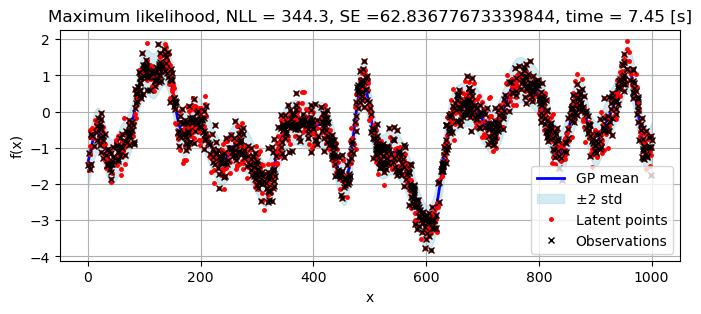

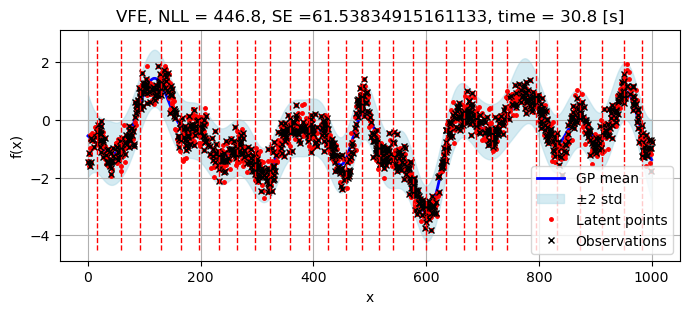

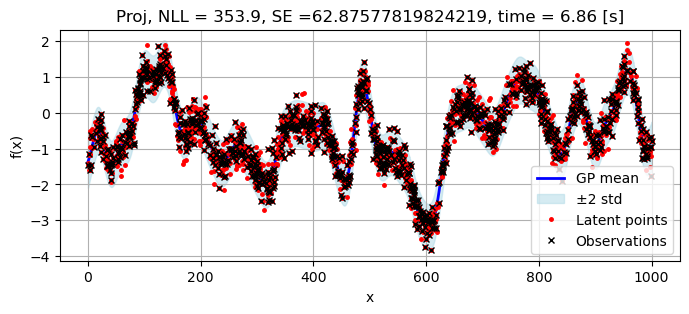

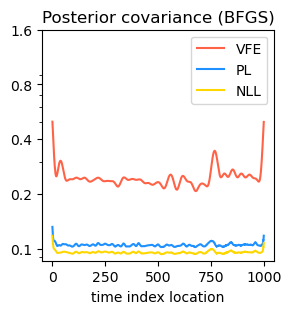

In [66]:
# plots
x_new = X_data.clone().detach()
x_new, _ = torch.sort(x_new, dim=0)  # returns sorted values
x_new = x_new.to(device)


#NLL
gp_nll.compute_moments()
mu1,var1 = gp_nll.forward(x_new)
SE1 = torch.norm(mu1-y_data)
ax = plot_gp(x_new, mu1, var1, X_obs=X_train, y_obs=y_train, X_latent=X_data, y_latent=y_data, 
             title = f"Maximum likelihood, NLL = {gp_nll.nll().cpu().detach().numpy().flatten()[0]:.1f}, SE ={SE1}, time = {d_train1['time']:.3g} [s]")

#print(var)
#ELBO
mu2,var2 = gp_elbo.forward_VFE(x_new)
SE2 = torch.norm(mu2-y_data)
ax = plot_gp(x_new, mu2, var2, X_obs=X_train, y_obs=y_train, X_latent=X_data, y_latent=y_data,
             title = f"VFE, NLL = {gp_elbo.nll().cpu().detach().numpy().flatten()[0]:.1f}, SE ={SE2}, time = {d_train2['time']:.3g} [s]")
Z_np = gp_elbo.Z.detach().cpu().numpy()
ax.vlines(Z_np, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1],
          colors="r", linestyles="--", linewidth=1.0)

#proj
gp_proj.compute_moments()
mu3,var3 = gp_proj.forward(x_new)
SE3 = torch.norm(mu3-y_data)
ax = plot_gp(x_new, mu3, var3, X_obs=X_train, y_obs=y_train, X_latent=X_data, y_latent=y_data,
             title = f"Proj, NLL = {gp_proj.nll().cpu().detach().numpy().flatten()[0]:.1f}, SE ={SE3}, time = {d_train3['time']:.3g} [s]")


#plot variances:
plt.figure(figsize=(3,3))
plt.semilogy(x_new.cpu().detach().numpy(), var2.cpu().detach().numpy(), color='tomato', label='VFE')
plt.semilogy(x_new.cpu().detach().numpy(), var3.cpu().detach().numpy(), color='dodgerblue', label='PL')
plt.semilogy(x_new.cpu().detach().numpy(), var1.cpu().detach().numpy(), color='gold', label='NLL')
plt.yticks([0.1, 0.2, 0.4, 0.8, 1.6],[0.1, 0.2, 0.4, 0.8, 1.6])
plt.title(f'Posterior covariance ({optimizer})')
plt.xlabel('time index location')
plt.legend()
plt.savefig(f"img/exp0-{optimizer}.pdf", bbox_inches='tight', pad_inches=0)





In [ ]:
X_data = X_data.to(device)
y_data = y_data.to(device)

In [11]:
gp_elbo.Z_.device

device(type='cuda', index=0)